## Importing important libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib #for loading nii files
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf #for deep learning

## Reading the metadata

In [2]:
data = pd.read_csv('../input/covid19-ct-scans/metadata.csv')
data.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


## Defining function for readiing .nii files

In [3]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

## Reading the chest ct scan data

In [4]:
# Read sample
sample_ct   = read_nii(data.loc[2,'ct_scan'])
sample_lung = read_nii(data.loc[2,'lung_mask'])
sample_infe = read_nii(data.loc[2,'infection_mask'])
sample_all  = read_nii(data.loc[2,'lung_and_infection_mask'])

## Plotting the sample images

Text(0.5, 1.0, 'Lung and Infection Mask')

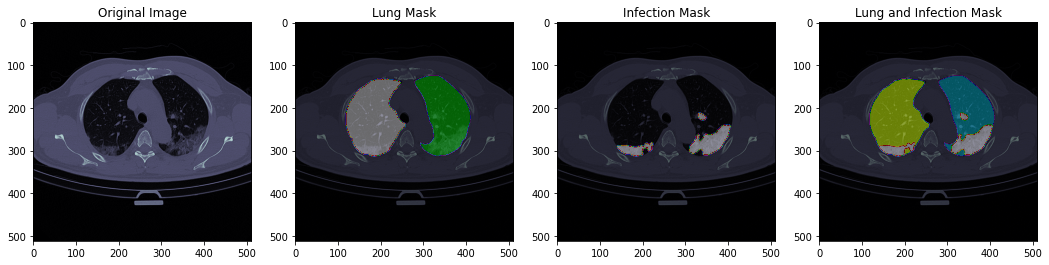

In [5]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

## Converting the data into array for training model

In [6]:
import numpy as np
import cv2
import random
from scipy.ndimage import rotate, shift, zoom

lungs = []
infections = []
case_ids = []
img_size = 256

# ----------- Load and Resize Data -----------
for case_index in range(len(data)):
    ct = read_nii(data['ct_scan'][case_index])
    infect = read_nii(data['infection_mask'][case_index])

    for slice_index in range(ct.shape[0]):
        lung_img = cv2.resize(ct[slice_index], dsize=(img_size, img_size)).astype('float32')
        infec_img = cv2.resize(infect[slice_index], dsize=(img_size, img_size)).astype('float32')

        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])
        case_ids.append(case_index)

In [7]:
import numpy as np

# case_ids should be a NumPy array telling which case each slice belongs to
# Convert and binarize
lungs = np.array(lungs, dtype=np.float32)
infections = (np.array(infections, dtype=np.uint8) > 0.5).astype(np.uint8)
case_ids = np.array(case_ids)

## Performing test and train split

In [8]:
# ----------- Case-wise Split -----------
unique_cases = np.unique(case_ids)
train_cases = unique_cases[4:20]
val_cases = unique_cases[:4]

train_mask = np.isin(case_ids, train_cases)
val_mask = np.isin(case_ids, val_cases)

lung_train = lungs[train_mask]
infect_train = infections[train_mask]
lung_test = lungs[val_mask]
infect_test = infections[val_mask]

print(f"✅ Train: {lung_train.shape[0]} slices from {len(train_cases)} cases")
print(f"✅ Validation: {lung_test.shape[0]} slices from {len(val_cases)} cases")

# ----------- Augmentation -----------
def augment_image(img, mask):
    if random.random() < 0.5:
        img = np.fliplr(img)
        mask = np.fliplr(mask)
    if random.random() < 0.5:
        img = np.flipud(img)
        mask = np.flipud(mask)

    angle = random.uniform(-15, 15)
    img = rotate(img, angle, reshape=False, order=1, mode='nearest')
    mask = rotate(mask, angle, reshape=False, order=0, mode='nearest')

    shift_val = np.random.uniform(-0.1, 0.1, size=2) * img.shape[:2]
    img = shift(img, shift=(*shift_val, 0), order=1, mode='nearest')
    mask = shift(mask, shift=(*shift_val, 0), order=0, mode='nearest')

    zoom_factor = random.uniform(0.9, 1.1)
    img = zoom(img, (zoom_factor, zoom_factor, 1), order=1)
    mask = zoom(mask, (zoom_factor, zoom_factor, 1), order=0)

    return fix_shape(img), fix_shape(mask)

def fix_shape(arr, target_size=(256, 256)):
    h, w, c = arr.shape
    th, tw = target_size
    dh = th - h
    dw = tw - w
    if dh > 0 or dw > 0:
        pad_h = (max(dh // 2, 0), max(dh - dh // 2, 0))
        pad_w = (max(dw // 2, 0), max(dw - dw // 2, 0))
        arr = np.pad(arr, (pad_h, pad_w, (0, 0)), mode='constant')
    arr = arr[:th, :tw, :]
    return arr.astype('float32')

# ----------- Apply Augmentation -----------
aug_lung_train = []
aug_infect_train = []

for i in range(len(lung_train)):
    img, mask = augment_image(lung_train[i], infect_train[i])
    aug_lung_train.append(img)
    aug_infect_train.append(mask)

lung_train = np.stack(aug_lung_train)
infect_train = np.stack(aug_infect_train)

# Final Binarization
infect_train = (infect_train > 0.5).astype(np.uint8)
infect_test = (infect_test > 0.5).astype(np.uint8)

print(f"✅ Augmented training shape: {lung_train.shape}")
print("✅ All preprocessing complete.")


✅ Train: 9143 slices from 16 cases
✅ Validation: 2048 slices from 4 cases
✅ Augmented training shape: (9143, 256, 256, 1)
✅ All preprocessing complete.


In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1.0

# Binary Dice coefficient
def dice_coef_infection(y_true, y_pred):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Binary IoU coefficient
def iou_coef_infection(y_true, y_pred):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Optional: KLD for experimentation
kld = tf.keras.losses.KLDivergence()


In [10]:
from tensorflow.keras.losses import BinaryCrossentropy

def loss_f(y_true, y_pred):
    bce = BinaryCrossentropy()
    return dice_loss(y_true, y_pred) + bce(y_true, y_pred) 

def loss_e(y_true, y_pred):
    bce = BinaryCrossentropy()
    return dice_loss(y_true, y_pred)  + kld(y_true, y_pred)
    
def dice_loss(y_true, y_pred):
    return 1. - dice_coef_infection(y_true, y_pred)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Multiply, Conv2D, DepthwiseConv2D, Dense, Flatten, MaxPooling2D, UpSampling2D, concatenate, Activation, LayerNormalization, Add, Dropout, Conv2DTranspose, multiply, Reshape, GlobalAveragePooling2D, Permute, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate

def activation_block(x):
    x = Activation("gelu")(x)
    return LayerNormalization()(x)

def conv_stem(x, filters: int, patch_size: int):
    x = Conv2D(filters, kernel_size=patch_size,padding='same', strides=patch_size)(x)
    return activation_block(x)

def vector_block(xyz, cmf, red):
    # red means reduction
    # cmf means filters, denotes vector size
    opt1 = conv_stem(xyz, cmf, red)
    opt2 = conv_stem(xyz, cmf, red)
    opt3 = conv_stem(xyz, cmf, red)
    opt4 = conv_stem(xyz, cmf, red)
    
    o1 = GlobalAveragePooling2D()(opt1)
    o2 = GlobalAveragePooling2D()(opt2)
    o3 = GlobalAveragePooling2D()(opt3)
    o4 = GlobalAveragePooling2D()(opt4)

    o5 = concatenate([o1, o2, o3, o4], -1)
    return o5

def mlp_feature(vect, cmf):
    oo = Flatten()(vect)
    o6 = Dense(cmf * 2, activation='gelu')(oo)
    o6 = Dropout(0.2)(o6)
    o6 = Dense(cmf * 4, activation='gelu')(o6)

    o6 = Reshape((1, cmf * 4))(o6)
    o7 = Permute((2, 1))(o6)

    o8 = multiply([o6, o7])
    o8 = Lambda(lambda x: tf.expand_dims(x, -1))(o8)
    o8 = MaxPooling2D(4)(o8)

    return o8

def frz_block(xyz):
    shape = xyz.shape
    a1, a2, a3, a4 = shape[0], shape[1], shape[2], shape[3]
    cmf = a2
    o5 = vector_block(xyz, cmf, 5)
    o7 = mlp_feature(o5, cmf)

    o7 = concatenate([o7, xyz, o7], -1)
    return o7

def up_frz(x1, x2, n_filters):
    # Upsample x1 using Conv2DTranspose
    x1 = Conv2DTranspose(n_filters * 4, 3, strides=2, activation='gelu', padding="same")(x1)
    
    # Apply Conv2D to x2
    x2 = Conv2D(n_filters * 2, 3, activation='gelu', padding="same")(x2)
    
    # Apply attention mechanism
    x = concatenate([x1, x2])
    
    # Apply Dropout for regularization
    x = Dropout(0.3)(x)
    
    return x

def regu(xyz, filt):
    x = Conv2D(filt, (3, 3), activation='gelu', padding="same")(xyz)
    x = MaxPooling2D(2)(x)
    return x

In [12]:
def squeeze_and_excite_block(inputs, ratio=24):
    """ Squeeze and Excitation block to recalibrate channel-wise features """
    filters = inputs.shape[-1]  # Number of input channels
    se_shape = (1, 1, filters)

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(inputs)
    se = Reshape(se_shape)(se)

    a = filters // ratio

    # Excitation: Dense layers to capture channel-wise dependencies
    if a > 8:
        se = Conv2D(filters // ratio, kernel_size=1, activation='swish', padding='same')(se)
        se = Conv2D(filters, kernel_size=1, activation='sigmoid', padding='same')(se)
    else:
        se = Conv2D(8, kernel_size=1, activation='swish', padding='same')(se)
        se = Conv2D(filters, kernel_size=1, activation='sigmoid', padding='same')(se)

    # Scale the input by channel-wise weights
    x = multiply([inputs, se])

    return x

def residual_block(x, filters, stride=1, padding='same'):
    shortcut = x
    x = Conv2D(filters * 6, 1, strides=stride, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = squeeze_and_excite_block(x)
    x = Conv2D(filters, 1, strides=stride, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Add()([x, shortcut])
    return x

def dense_block(inputs, num_layers, growth_rate, ratio=16):
    """Dense block where each layer is connected to all previous layers."""
    concat_features = inputs
    for i in range(num_layers):
        # BatchNorm -> ReLU -> Conv2D
        x = Conv2D(growth_rate, 3, activation='gelu', padding='same')(concat_features)

        # Concatenate input with new output (dense connection)
        concat_features = Concatenate()([concat_features, x])

    x = squeeze_and_excite_block(concat_features)

    x = MaxPooling2D(2)(x)

    return x

inputs = (img_size, img_size, 1)

def model_build_func(input_shape, n_labels):
    inputs = Input(shape=input_shape, name='input_image')
    g_filter = 32
    u_filter = 8

    o1 = frz_block(regu(inputs, g_filter))  # 80

    o2 = frz_block(regu(o1, g_filter * 2))  # 40

    o3 = frz_block(regu(o2, g_filter * 4))  # 20

    o4 = frz_block(regu(o3, g_filter * 8))  # 10

    o5 = frz_block(regu(o4, g_filter * 16))  # 5

    # middle part

    u1 = up_frz(o5, o4, u_filter * 16)  # 10

    cu1 = concatenate([u1, o4])  # 10

    u2 = up_frz(cu1, o3, u_filter * 8)  # 20

    cu2 = concatenate([u2, o3])  # 20

    u3 = up_frz(cu2, o2, u_filter * 4)  # 40

    cu3 = concatenate([u3, o2])  # 40

    u4 = up_frz(cu3, o1, u_filter * 2)  # 40

    cu4 = concatenate([u4, o1])  # 40

    ex_u = UpSampling2D(2)(o1)

    u5 = up_frz(cu4, ex_u, u_filter)  # 40

    seg_map = Conv2D(n_labels, 3, activation='sigmoid', padding="same")(u5)

    model = Model(inputs=inputs, outputs=seg_map)

    return model


model = model_build_func(inputs, 1)

from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model):
    """Calculate Floating Point Operations (FLOPs) of a Keras model in TensorFlow 2.x."""
    # Convert Keras model to a TensorFlow function
    concrete_func = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.input.dtype)
    )

    # Convert to frozen graph
    frozen_func, _ = convert_variables_to_constants_v2_as_graph(concrete_func)

    # Compute FLOPs
    flops = tf.compat.v1.profiler.profile(
        frozen_func.graph,
        options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation(),
    )

    return flops.total_float_ops

# Compute FLOPs
flops = get_flops(model)
print(f"Total FLOPs: {flops / 1e9:.2f} GFLOPs")  # Convert to GFLOPs

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=loss_f, metrics=[dice_coef_infection, iou_coef_infection])

# Model summary
model.summary()


Total FLOPs: 10.43 GFLOPs
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 128)  102528      max_pooling2d[0][0]              
____________________________________________________________________

In [13]:
# Install required packages
!pip install openpyxl

# Imports
import openpyxl  # required for reading .xlsx files
import pandas as pd
import tensorflow as tf
import os
import shutil
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

# File paths
checkpoint_filepath = '/kaggle/working/checkpoint.h5.keras'
metrics_file = '/kaggle/working/training_metrics.xlsx'
pre_checkpoint_filepath = '/kaggle/input/dseg-unet-4channel-covid19/checkpoint.h5.keras'
pre_metrics_file = '/kaggle/input/dseg-unet-4channel-covid19/training_metrics.xlsx'

# Restore checkpoint and metrics if available
if os.path.exists(pre_checkpoint_filepath):
    shutil.copy(pre_checkpoint_filepath, checkpoint_filepath)
    print(f"Restored checkpoint from: {pre_checkpoint_filepath}")

if os.path.exists(pre_metrics_file):
    shutil.copy(pre_metrics_file, metrics_file)
    print(f"Restored metrics file from: {pre_metrics_file}")

# Load last epoch
def load_last_epoch():
    if os.path.exists(metrics_file):
        try:
            df = pd.read_excel(metrics_file, engine='openpyxl')
            if not df.empty and 'epoch' in df.columns:
                return df['epoch'].iloc[-1] + 1
        except Exception as e:
            print(f"⚠️ Could not read metrics file: {e}")
    return 0

last_epoch = load_last_epoch()

# Get best validation loss from previous runs
def get_best_val_loss():
    if os.path.exists(metrics_file):
        try:
            df = pd.read_excel(metrics_file, engine='openpyxl')
            if 'val_loss' in df.columns and not df['val_loss'].isnull().all():
                return df['val_loss'].min()
        except Exception as e:
            print(f"⚠️ Could not read val_loss from metrics file: {e}")
    return float('inf')

best_val_loss = get_best_val_loss()

# Custom model checkpoint
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        self.best_loss = best_val_loss

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if current_loss is not None and current_loss < self.best_loss:
            self.best_loss = current_loss
            self.model.save(self.filepath)
            print(f"✅ Model saved at epoch {epoch + 1} with val_loss: {current_loss:.4f}")

# === Learning Rate Schedule ===
def lr_schedule(epoch, lr):
    return 1e-4 if epoch >= 5 else lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Logger for Excel
class MetricsLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        df_new = pd.DataFrame([{**logs, 'epoch': epoch}])
        try:
            if os.path.exists(metrics_file):
                df = pd.read_excel(metrics_file, engine='openpyxl')
                df = pd.concat([df, df_new], ignore_index=True)
            else:
                df = df_new
            df.to_excel(metrics_file, index=False, engine='openpyxl')
        except Exception as e:
            print(f"⚠️ Failed to log metrics: {e}")

# Early stopping with patience and saving best weights
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=20):
        super().__init__()
        self.patience = patience
        self.wait = 0
        self.best_loss = best_val_loss

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if current_loss is None:
            return
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0
            self.model.save_weights(checkpoint_filepath)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"🛑 Early stopping at epoch {epoch + 1}")
                self.model.stop_training = True


# Final callbacks list
callbacks = [
    CustomModelCheckpoint(filepath=checkpoint_filepath),
    MetricsLogger(),
    lr_scheduler,
    CustomEarlyStopping(patience=20)
]


     |████████████████████████████████| 251 kB 4.4 MB/s eta 0:00:01


## Training the model

In [14]:
import time
import os
import pandas as pd
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model

EPOCHS = 200

# Record the start time
start_time = time.time()

# === Load last completed epoch from metrics file ===
def load_last_epoch():
    if os.path.exists(pre_metrics_file):
        try:
            df = pd.read_excel(pre_metrics_file, engine='openpyxl')
            if not df.empty and 'epoch' in df.columns:
                return int(df['epoch'].iloc[-1]) + 1
        except Exception as e:
            print(f"⚠️ Failed to read metrics file: {e}")
    return 0

last_epoch = load_last_epoch()

# === Load pretrained weights if available ===
if os.path.exists(pre_checkpoint_filepath):
    print("✅ Checkpoint found. Loading pretrained weights...")
    model.load_weights(pre_checkpoint_filepath)
    print(f"🔁 Resuming training from epoch {last_epoch}")
else:
    print("🆕 No checkpoint found. Starting training from scratch.")
    last_epoch = 0

# === Prepare input and label tensors ===
lung_train = np.asarray(lung_train, dtype=np.float16)
infect_train = np.asarray(infect_train, dtype=np.uint8)

lung_test = np.asarray(lung_test, dtype=np.float16)
infect_test = np.asarray(infect_test, dtype=np.uint8)

# === Data Generator ===
class LungDataGenerator(Sequence):
    def __init__(self, X, Y, batch_size=8, shuffle=True):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_ids = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_ids]
        Y_batch = self.Y[batch_ids]
        return np.asarray(X_batch, dtype=np.float16), np.asarray(Y_batch, dtype=np.uint8)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# === Create generators ===
train_gen = LungDataGenerator(lung_train, infect_train, batch_size=8)
val_gen = LungDataGenerator(lung_test, infect_test, batch_size=8, shuffle=False)

# === Train the model ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    initial_epoch=last_epoch,
    callbacks=callbacks
)

# === Timing info ===
end_time = time.time()
total_time = end_time - start_time
print(f"✅ Total training time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")


🆕 No checkpoint found. Starting training from scratch.
Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
1143/1143 [==============================] - 169s 135ms/step - loss: 1.3025 - dice_coef_infection: 0.0899 - iou_coef_infection: 0.0509 - val_loss: 0.5179 - val_dice_coef_infection: 0.5631 - val_iou_coef_infection: 0.5494
✅ Model saved at epoch 1 with val_loss: 0.5179
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
1143/1143 [==============================] - 152s 133ms/step - loss: 0.8082 - dice_coef_infection: 0.2463 - iou_coef_infection: 0.1544 - val_loss: 0.4716 - val_dice_coef_infection: 0.5526 - val_iou_coef_infection: 0.5146
✅ Model saved at epoch 2 with val_loss: 0.4716
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
1143/1143 [==============================] - 152s 133ms/step - loss: 0.6464 - dice_coef_infection: 0.4024 - iou_coef_i

## Plotting the performance metrics

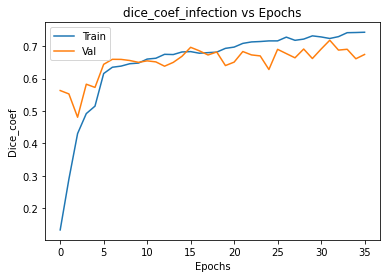

In [15]:
plt.plot(history.history['dice_coef_infection'])
plt.plot(history.history['val_dice_coef_infection'])
plt.title('dice_coef_infection vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice_coef')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

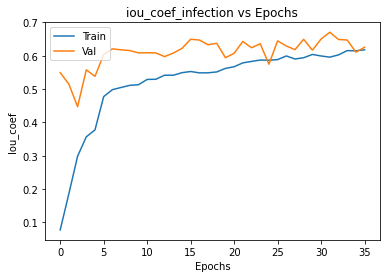

In [16]:
plt.plot(history.history['iou_coef_infection'])
plt.plot(history.history['val_iou_coef_infection'])
plt.title('iou_coef_infection vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Iou_coef')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

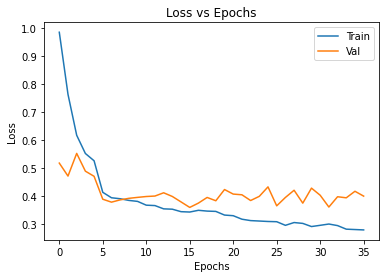

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

## Using our trained model for prediction

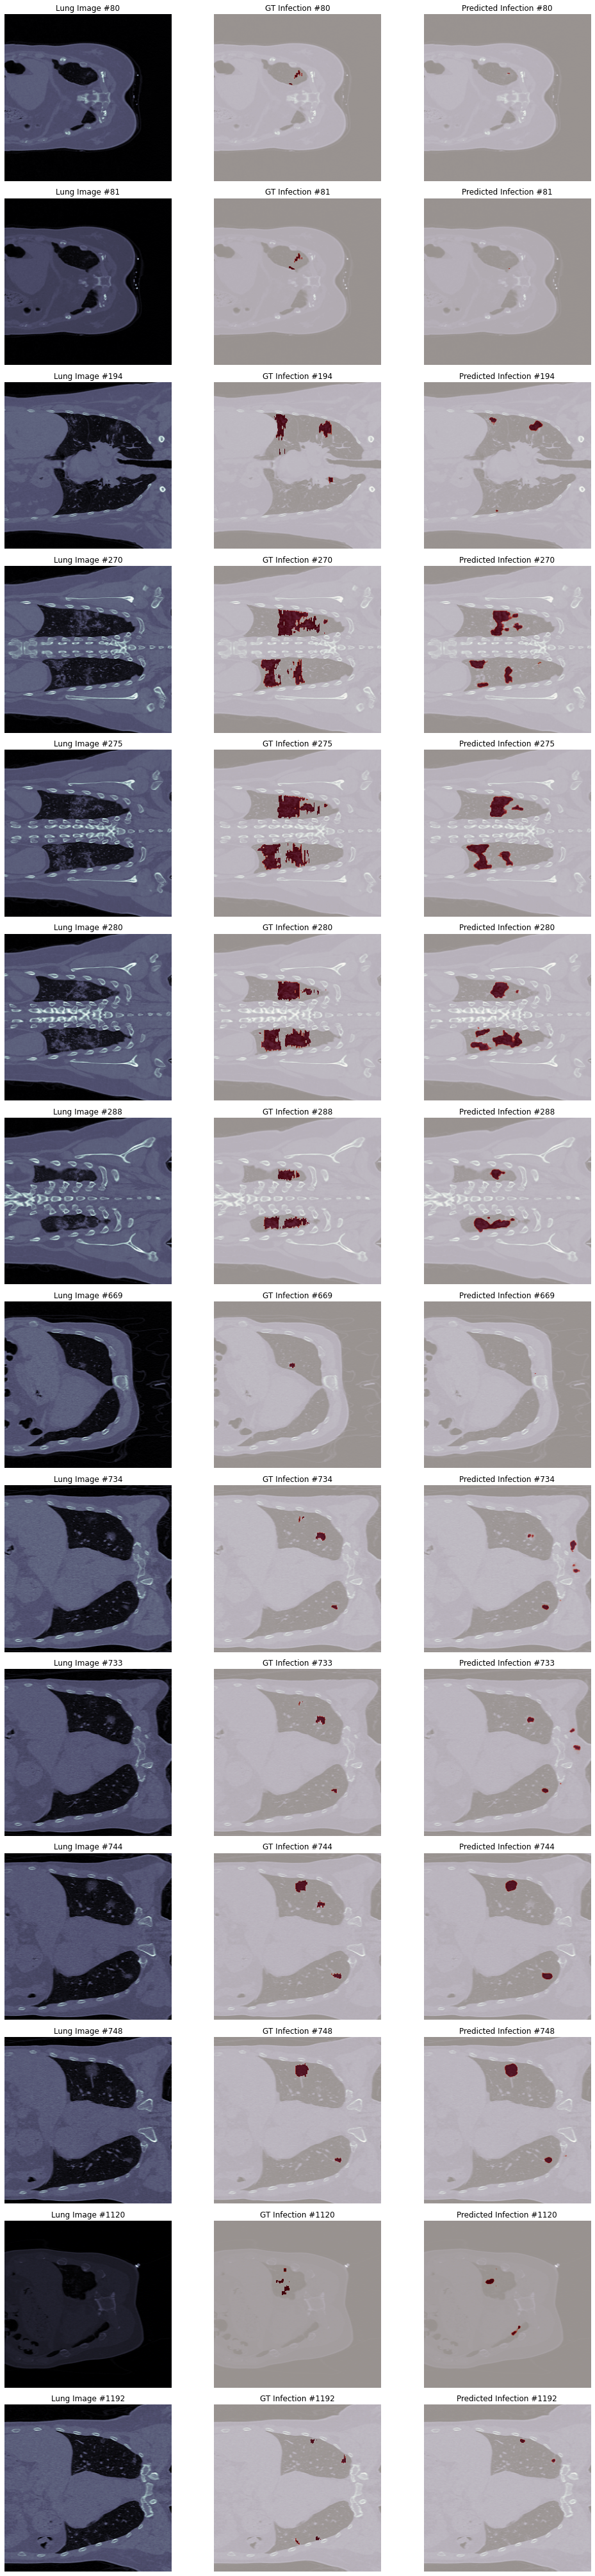

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Run inference if not already done
predicted = model.predict(lung_test)

# Selected indices to visualize
selected_indices = [80, 81, 194, 270, 275, 280, 288, 669, 734, 733, 744, 748, 1120, 1192]
n_samples = len(selected_indices)

# Plot
fig, axes = plt.subplots(n_samples, 3, figsize=(15, n_samples * 4))
fig.subplots_adjust(hspace=0.4)

for j, i in enumerate(selected_indices):
    lung_img = lung_test[i][..., 0].astype(np.float32)
    gt_infect = (infect_test[i][..., 0] > 0.5).astype(np.float32)
    pred_infect = predicted[i][..., 0].astype(np.float32)

    # Normalize lung image
    if lung_img.max() > lung_img.min():
        lung_img = (lung_img - lung_img.min()) / (lung_img.max() - lung_img.min())
    lung_img = np.clip(lung_img, 0, 1)
    pred_infect = np.clip(pred_infect, 0, 1)

    # Column 1: Original Lung
    axes[j, 0].imshow(lung_img, cmap='bone')
    axes[j, 0].set_title(f'Lung Image #{i}')
    axes[j, 0].axis('off')

    # Column 2: Ground Truth Infection
    axes[j, 1].imshow(lung_img, cmap='bone')
    axes[j, 1].imshow(gt_infect, cmap='Reds', alpha=0.6)
    axes[j, 1].set_title(f'GT Infection #{i}')
    axes[j, 1].axis('off')

    # Column 3: Predicted Infection
    axes[j, 2].imshow(lung_img, cmap='bone')
    axes[j, 2].imshow(pred_infect, cmap='Reds', alpha=0.6)
    axes[j, 2].set_title(f'Predicted Infection #{i}')
    axes[j, 2].axis('off')

plt.tight_layout()
plt.show()